In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')

In [2]:
data_path = 'exports/donor_id.h5ad'

In [3]:
adata_org = sc.read_h5ad(data_path)

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata = sc.AnnData(
    adata_org.obsm['map_latent_summed'].copy(),
    obs=adata_org.obs.copy(),
    obsm=adata_org.obsm.copy()
)

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
import matplotlib.pyplot as plt
import umap

2025-12-03 01:34:01.493651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-03 01:34:01.545084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-03 01:34:01.545386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-03 01:34:01.620450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 01:34:02.405581: W tensorflow/compiler/tf

In [8]:
# UMAP on last level
umap_model = umap.UMAP(n_components=2, random_state=1)

umap_model.fit(adata.obsm['map_latent_summed'][adata.obs['level'] == 15])

/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/SE/miniconda3/envs/trials/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


,n_neighbors,15
,n_components,2
,metric,'euclidean'
,metric_kwds,None
,output_metric,'euclidean'
,output_metric_kwds,None
,n_epochs,None
,learning_rate,1.0
,init,'spectral'
,min_dist,0.1
,spread,1.0


In [10]:
# Infer on all other levels
X_umap = umap_model.transform(adata.obsm['map_latent_summed'])

# Store the result in adata_cat
adata.obsm['X_umap_fit'] = X_umap

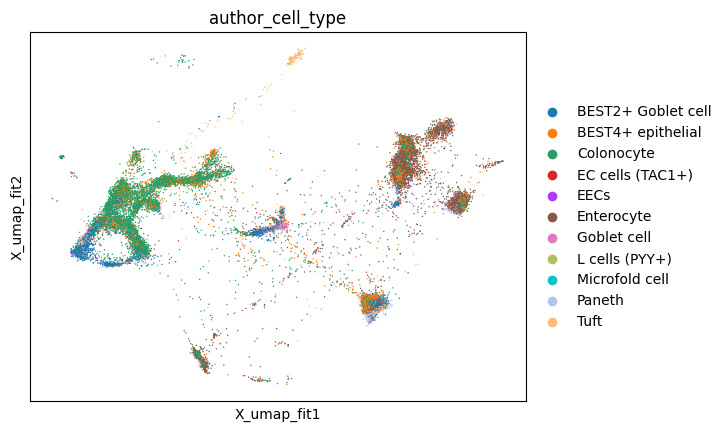

In [15]:
sc.pl.embedding(adata[adata.obs['level'] == 4], basis='X_umap_fit', color=['author_cell_type'])

In [ ]:
# adata = adata[adata.obs['organism_part'] == 'liver']

In [ ]:
adata.obs['author_cell_type'].value_counts() / 16

In [ ]:
from copy import deepcopy
import numpy as np
import pandas as pd

def get_tree(
    adata, 
    final_level=15,
    step=2,
    cell_type_key='cell_type',

    n_comps=15,
    standardize=True,
    random_state=0,
    n_pcs=30,
    obsm_key=None,
    dynamic_comps=False,
    ):

    clusters = adata.obs[cell_type_key].unique().tolist()
    new_clusters = deepcopy(clusters)
    
    mappings = {}
    merged_levels = {}
    
    current_level = final_level
    iter_step = 1
    rows = []
    pair_purities = []        # per-merge purity
    pair_cell_counts = []     # per-merge cell counts (for weighting)

    while True:
        
        adata_subset = adata[adata.obs['level'] == current_level].copy()
        adata_subset.obs[cell_type_key] = adata_subset.obs[cell_type_key].astype(str)
                
        for mapping_key, mapping_value in mappings.items():
            adata_subset.obs[cell_type_key] = adata_subset.obs[cell_type_key].replace(mapping_key, mapping_value)

        if dynamic_comps is not False:
            n_comps = len(adata_subset.obs[cell_type_key].unique()) + dynamic_comps
    
        labels = GM.em_cluster(
            adata=adata_subset,
            n_comps=n_comps,
            cell_type_key=cell_type_key,
            obsm_key=obsm_key,
            n_pcs=n_pcs,
            standardize=standardize,
            random_state=random_state,
        )
        
        # raw counts per (cell_type, mixture_component)
        raw_counts_df = pd.crosstab(adata_subset.obs[cell_type_key], labels)
        # normalized for similarity (as before)
        counts_df = (raw_counts_df.T / raw_counts_df.sum(axis=1)).T
    
        X = counts_df.fillna(0.0).to_numpy()
        G = X @ X.T  # pairwise dot products (similarities)
        np.fill_diagonal(G, -np.inf)  # exclude self
    
        i, j = np.unravel_index(np.argmax(G), G.shape)
        best_pair = (counts_df.index[i], counts_df.index[j])
        best_pair = list(best_pair)

        # ---- NEW: purity of this merge ---------------------------------
        # components used by best_pair
        pair_rows = counts_df.loc[best_pair]
        # components used by others
        other_rows = counts_df.drop(index=best_pair) if len(counts_df) > 2 else pd.DataFrame()

        comp_used_by_pair = (pair_rows > 0).any(axis=0)
        if not other_rows.empty:
            comp_used_by_others = (other_rows > 0).any(axis=0)
        else:
            comp_used_by_others = pd.Series(False, index=counts_df.columns)

        pure_comp_mask = comp_used_by_pair & (~comp_used_by_others)
        pure_components = counts_df.columns[pure_comp_mask]

        # # of cells from best_pair in pure vs total components
        pair_total_cells = raw_counts_df.loc[best_pair].values.sum()
        if pair_total_cells > 0 and len(pure_components) > 0:
            pair_pure_cells = raw_counts_df.loc[best_pair, pure_components].values.sum()
            pair_purity = pair_pure_cells / pair_total_cells
        else:
            pair_purity = 0.0

        pair_purities.append(float(pair_purity))
        pair_cell_counts.append(int(pair_total_cells))
        # -----------------------------------------------------------------

        for pair in best_pair:
            mappings[pair] = '&'.join(best_pair)
        merged_levels[current_level] = best_pair
        
        current_level -= step

        n_samples = sum([_.count('&') + 1 for _ in best_pair])
        row = [new_clusters.index(best_pair[0]), new_clusters.index(best_pair[1]), float(iter_step), n_samples]
        rows.append(row)
        new_clusters.append('&'.join(best_pair))
        iter_step += 1
        
        if len(counts_df) == 2:
            break
        elif current_level < 1:
            print('Reached lowest level.')
            current_level = 0

    linkage_mtx = np.array(rows)

    if pair_cell_counts:
        overall_tree_purity = float(
            np.average(pair_purities, weights=pair_cell_counts)
        )
    else:
        overall_tree_purity = np.nan

    tree_results = {
        'merged_levels': merged_levels,
        'linkage_mtx': linkage_mtx,
        'clusters': clusters,
        'pair_purities': pair_purities,           # per merge
        'pair_cell_counts': pair_cell_counts,     # weights
        'overall_tree_purity': overall_tree_purity,  # your GM-based purity
    }
    return tree_results

In [ ]:
import GM

In [ ]:
tree_results = get_tree(
    adata, 
    final_level=15,
    step=2,
    cell_type_key='author_cell_type',

    n_comps=65,
    standardize=True,
    random_state=0,
    n_pcs=30,
    obsm_key=None,
    dynamic_comps=False,
    )

In [ ]:
tree_results['overall_tree_purity']

In [ ]:
# 15 0.32

# 85 0.36

# 35 0.368

# 45 0.364

# 65 0.388

In [ ]:
GM.plot_dendro(
    tree_results['linkage_mtx'], 
    tree_results['clusters'], 
    figsize=(12, 6),
    linewidth=2.5,
    orientation='right',
    save_path = None
    )

In [ ]:
adata.obs['author_cell_type'].value_counts() / 16

In [ ]:
# pd.crosstab(adata.obs['cell_type'], adata.obs['age'])